# Helment and Mask Detection

I have used Yolov3 as an object detection model to train 4 classes - 

head,
helmet and mask,
mask,
helmet

I have chosen yolo, because it is quite fast on par with mobilenet-SSD, gives a median accuracy with less data and training time.

In [31]:
# Tweak this options for data, training, testing, infer

data_prep_flag = True
data_train_flag = True
data_test_flag = True
data_infer_flag = False

## Data Prep

Used annotation.xml file to prepare training data in yolo format, contains text files in labels and images in images folder.

In [4]:
# Prep of Training Data Format from Annotation for yolo

if data_prep_flag:

    import xml.etree.ElementTree as et
    import shutil 

    xtree = et.parse("data/annotations.xml")
    xroot = xtree.getroot()

    def convert(size, box):
        dw = 1./(size[0])
        dh = 1./(size[1])
        x = (box[0] + box[1])/2.0 - 1
        y = (box[2] + box[3])/2.0 - 1
        w = box[1] - box[0]
        h = box[3] - box[2]
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh
        return x,y,w,h

    for node in xroot.iter('image'):
        rows = []
        id_ = node.attrib.get("id")
        name = node.attrib.get("name")
        width = node.attrib.get("width")
        height = node.attrib.get("height")

        root1 = et.Element('root')
        root1 = node

        head_list = list()
        for supply in root1.iter('box'):
            label = supply.attrib.get("label")
            if label == "head":
                occluded = supply.attrib.get("occluded")
                xtl = supply.attrib.get("xtl")
                ytl = supply.attrib.get("ytl")
                xbr = supply.attrib.get("xbr")
                ybr = supply.attrib.get("ybr")
                #print(convert([float(width), float(height)], [float(xtl), float(xbr), float(ytl), float(ybr)]))         

                x, y, w, h = convert([float(width), float(height)], [float(xtl), float(xbr), float(ytl), float(ybr)])

                attr_dict = {}

                root2 = et.Element('root')
                root2 = supply
                for at in root2.iter('attribute'):
                    attr_dict[str(at.attrib.get("name"))] = at.text

                if attr_dict['mask'] == 'yes' and attr_dict['has_safety_helmet'] == 'yes':
                    rows.append((1, x, y, w, h))
                elif attr_dict['mask'] == 'yes':
                    rows.append((2, x, y, w, h))
                elif attr_dict['has_safety_helmet'] == 'yes':
                    rows.append((3, x, y, w, h))
                else:
                    rows.append((0, x, y, w, h))

            #print(attr_dict)
        #print(rows)
        #print(id_)

        with open("data/labels/"+str(id_)+".txt", "w") as text_file:
            for i in rows:
                j = str(i).replace(',', '')
                text_file.write(j[1:len(j)-1]+'\n')

        shutil.copyfile("data/images_all/"+id_+".jpg", "data/images/"+id_+".jpg")
    #print(rows)

## Train-Test Set

Created train and test set files for training and validation accuracy, used 20% for test set.

In [34]:
# Data Parameters

if data_prep_flag:

    # Train_Test Data Prep
    import glob
    import os

    current_dir = "data/images"
    # Percentage of images to be used for the valid set
    percentage_test = 20
    # Create train.txt and valid.txt
    file_train = open('data/train.txt', 'w')
    file_test = open('data/test.txt', 'w')
    # Populate train.txt and valid.txt
    counter = 1
    index_test = round(100 / percentage_test)
    for file in glob.iglob(os.path.join(current_dir, '*.jpg')):
        title, ext = os.path.splitext(os.path.basename(file))
        if counter == index_test:
            counter = 1
            file_test.write(current_dir +"/" +title + '.jpg' + "\n")
        else:
            file_train.write(current_dir +"/" +title + '.jpg' + "\n")
        counter = counter + 1


## Training the Model

Used yolov3 tiny arch for reduced training time, used a pre-trained model for initializing weights

Have used darknet repo for yolo: https://github.com/AlexeyAB/darknet

In [36]:
# Training Model using Darknet Yolov3 repo

if data_train_flag:
    
    import os
    cmd = './darknet detector train data/detector.data data/yolov3-helmet.cfg data/darknet53.conv.74'
    so = os.popen(cmd).read()
    print(so)

## Testing the trained Model on Test Set

I will be generating data to test based on our test set on the model,

For metrics I have used: https://github.com/Cartucho/mAP

In [44]:
# Testing Model on Test data generated during training
# First Getting Annotations for ground Truth from XML
# Second Generating results from the model
# Calculating mAP

if data_test_flag:
    
    import xml.etree.ElementTree as et
    import cv2
    import numpy as np
    
    # Ground Truth Annotations
    xtree = et.parse("data/annotations.xml")
    xroot = xtree.getroot()

    with open('data/test.txt') as f:
        lines = f.read().splitlines()

    test_id_list = [i.split('/')[-1].split('.')[0] for i in lines]

    for node in xroot.iter('image'):

        rows = []
        id_ = node.attrib.get("id")

        if id_ in test_id_list:
            name = node.attrib.get("name")
            width = node.attrib.get("width")
            height = node.attrib.get("height")

            root1 = et.Element('root')
            root1 = node

            head_list = list()
            for supply in root1.iter('box'):
                label = supply.attrib.get("label")
                if label == "head":
                    occluded = supply.attrib.get("occluded")
                    xtl = float(supply.attrib.get("xtl"))
                    ytl = float(supply.attrib.get("ytl"))
                    xbr = float(supply.attrib.get("xbr"))
                    ybr = float(supply.attrib.get("ybr"))
                    attr_dict = {}

                    root2 = et.Element('root')
                    root2 = supply
                    for at in root2.iter('attribute'):
                        attr_dict[str(at.attrib.get("name"))] = at.text

                    if attr_dict['mask'] == 'yes' and attr_dict['has_safety_helmet'] == 'yes':
                        rows.append((1, xtl, ytl, xbr, ybr))
                    elif attr_dict['mask'] == 'yes':
                        rows.append((2, xtl, ytl, xbr, ybr))
                    elif attr_dict['has_safety_helmet'] == 'yes':
                        rows.append((3, xtl, ytl, xbr, ybr))
                    else:
                        rows.append((0, xtl, ytl, xbr, ybr))

            with open("data/input/ground-truth/"+str(id_)+".txt", "w") as text_file:
                for i in rows:
                    j = str(i).replace(',', '')
                    text_file.write(j[1:len(j)-1]+'\n')
    
    
    
    # Generating Test results from the model
    with open('data/test.txt') as f:
        lines = f.read().splitlines()

    image_list = [i.strip("data/") for i in lines]

    print(image_list)
    
    config_file = 'data/yolov3-helmet.cfg'
    weights_file = 'backup/yolov3-helmet.weights'
    names_file = 'data/data.names'

    CONF_THRESH, NMS_THRESH = 0.5, 0.5

    # Load the network
    net = cv2.dnn.readNetFromDarknet(config_file, weights_file)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    # Get the output layer from YOLO
    layers = net.getLayerNames()
    output_layers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # Read and convert the image to blob and perform forward pass to get the bounding boxes with their confidence scores
    for i in image_list:
        img = cv2.imread('data/'+i)
        height, width = img.shape[:2]
        #print(height, width)

        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        layer_outputs = net.forward(output_layers)

        class_ids, confidences, b_boxes = [], [], []
        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > CONF_THRESH:
                    center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    b_boxes.append([x, y, int(w), int(h)])
                    confidences.append(float(confidence))
                    class_ids.append(int(class_id))

        # Perform non maximum suppression for the bounding boxes to filter overlapping and low confident bounding boxes
        #print(cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH))
        try:
            indices = cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH).flatten().tolist()

            # Draw the filtered bounding boxes with their class to the image
            with open(names_file, "r") as f:
                classes = [line.strip() for line in f.readlines()]
            colors = np.random.uniform(0, 255, size=(len(classes), 3))

            rows = []

            for index in sorted(indices):
                x, y, w, h = b_boxes[index]
                rows.append((class_ids[index], CONF_THRESH, float(x), float(y), float(x + w), float(y + h)))
                #print((x, y), (x + w, y + h), class_ids[index])

            with open("data/input/detection-results/"+str(i.split('/')[-1].split('.')[0])+".txt", "w") as text_file:
                for i in rows:
                    j = str(i).replace(',', '')
                    text_file.write(j[1:len(j)-1]+'\n')
        except:
            pass
    
    # Calc mAP
    import os
    cmd = 'python3 data/scripts/extra/intersect-gt-and-dr.py'
    so = os.popen(cmd).read()
    print(so)
    
    cmd = 'python3 data/calc_mAp.py'
    so = os.popen(cmd).read()
    print(so)

['images/223.jpg', 'images/50.jpg', 'images/150.jpg', 'images/145.jpg', 'images/587.jpg', 'images/231.jpg', 'images/475.jpg', 'images/257.jpg', 'images/242.jpg', 'images/245.jpg', 'images/84.jpg', 'images/339.jpg', 'images/581.jpg', 'images/136.jpg', 'images/199.jpg', 'images/317.jpg', 'images/216.jpg', 'images/280.jpg', 'images/239.jpg', 'images/374.jpg', 'images/219.jpg', 'images/549.jpg', 'images/52.jpg', 'images/324.jpg', 'images/160.jpg', 'images/445.jpg', 'images/452.jpg', 'images/541.jpg', 'images/44.jpg', 'images/328.jpg', 'images/188.jpg', 'images/559.jpg', 'images/303.jpg', 'images/32.jpg', 'images/399.jpg', 'images/453.jpg', 'images/306.jpg', 'images/241.jpg', 'images/157.jpg', 'images/305.jpg', 'images/124.jpg', 'images/441.jpg', 'images/433.jpg', 'images/531.jpg', 'images/284.jpg', 'images/125.jpg', 'images/442.jpg', 'images/464.jpg', 'images/0.jpg', 'images/53.jpg', 'images/41.jpg', 'images/601.jpg', 'images/9.jpg', 'images/264.jpg', 'images/274.jpg', 'images/519.jpg', 'i

## Detection Metrics

mAP was introduced in the PASCAL VOC 2012 competition, since then it has been the prime metric of object detection methods,

The standard evaluation metric of classification models such as classification accuracy, f1-score holds well when dealing with singular loss functions such as entropy, whereas in object detection methods its always dual loss(classification and detection), so it should take into account both of them.

Based on IoU of anchor boxes area under curve is calculated,

Some other metrics have also been calculated: Log average miss rate,
, Ground Truth by Classes, Detection Results - False Positive and True Positive

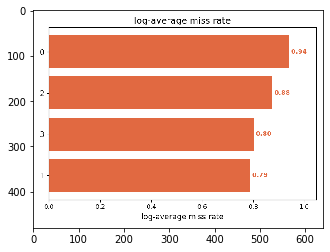

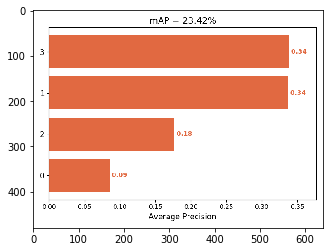

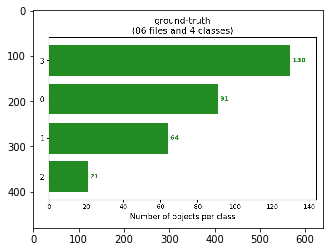

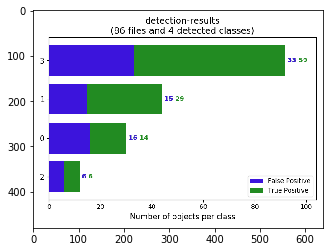

In [10]:
# Test Results 

# 4 Metric Plots
# Log average miss rate
# mAP
# Ground Truth by Classes
# Detection Results - False Positive and True Positive

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

im = ['data/output/lamr.png', 'data/output/mAP.png', 'data/output/ground-truth-info.png', 'data/output/detection-results-info.png']

for i in im:
    ik = cv2.imread(i)

    plt.imshow(ik)
    plt.show()

In [7]:
# Inference on a single image using model

if data_infer_flag:
    
    import subprocess
    image_path = ""
    subprocess.Popen("python3 inference.py --image " + image_path + " --config yolov3-helmet.cfg --weights backup/yolov3-helmet_20000.weights --names  data/data.names ")